In [1]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/embedding/embeddings.npy
/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv


Let's split into training and test sets

In [2]:
data_folder = '/kaggle/input/imdb-dataset-of-50k-movie-reviews/IMDB Dataset.csv'
df = pd.read_csv(data_folder)

from sklearn.model_selection import train_test_split

# Create a mapping dictionary
label_mapping = {'positive': 1, 'negative': 0}

# Convert labels using the mapping dictionary
df['sentiment'] = df['sentiment'].map(label_mapping)

# Split the data into train and test sets
train_df, test_df = train_test_split(df, test_size=0.5, random_state=1234)


# Example usage
print("Train set size:", len(train_df))
print("Test set size:", len(test_df))

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Train set size: 25000
Test set size: 25000


In [3]:
train_df.head()

,review,sentiment
23420,...And that's why hard to rate. <br /><br />Fr...,0
43821,Some have praised _Atlantis:_The_Lost_Empire_ ...,0
21387,This film says everything there is to say abou...,1
17127,"Last time I checked, the Nazis didn't win the ...",0
3642,I wish Depardieu had been able to finish his b...,0


## Data preprocessing 

In [4]:
from nltk.corpus import stopwords
import nltk 
stop_words = set(stopwords.words('english'))

In [5]:
import re
import string
from string import digits
from collections import Counter
from torchtext.data.utils import get_tokenizer

# Define the tokenizer
tokenizer = get_tokenizer('basic_english')


def stringprocess(text):
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    text = re.sub('\W', ' ', text)
    text = re.sub('\s+', ' ', text)
    text = re.sub(r"\#", "", text)
    text = re.sub(r"http\S+","URL", text)
    text = re.sub(r"@", "", text)
    text = re.sub(r"[^A-Za-z0-9()!?\'\`\"]", " ", text)
    text = re.sub("\s{2,}", " ", text)
    text = text.strip(' ')
    text = text.lower()
    
    return text

def tokenprocess(text):
    text_tokens = tokenizer(text)
    # Filter tokens based on their frequency
    filtered_tokens = [token for token in text_tokens if token not in stop_words]
    return filtered_tokens


Define vocabulary from text

In [6]:
import matplotlib.pyplot as plt



X = df["review"]

X = X.apply(stringprocess)
word_tokens = list(X.apply(tokenprocess))

word_tokens_flat = [item for sublist in word_tokens for item in sublist]

# Collect unique tokens from the dataset
vocab = set()
for data_point in word_tokens:
    vocab.update(data_point)

# Step 1: Determine word frequencies
word_frequency = {}
for word in word_tokens_flat:
    if word in word_frequency:
        word_frequency[word] += 1
    else:
        word_frequency[word] = 1

# Step 2: Define threshold frequency
threshold = 4

# Step 3: Create filtered list
vocab = [word for word in vocab if word_frequency[word] >= threshold]

# Convert the set of unique tokens to a list
vocab = list(vocab)
vocab = ['<pad>'] + vocab 

print(len(vocab))

# Example usage: Print the vocabulary
print(vocab[:50])

# Count the number of tokens per data point
token_counts = []
for data_point in word_tokens:
    token_count = len(data_point)
    token_counts.append(token_count)

44127
['<pad>', 'deservingly', 'zarkov', 'sept', 'philippines', 'frees', 'wickerman', 'documentry', 'awww', 'vistas', 'retrieval', 'rambled', 'dim', 'contacted', 'mavens', 'sverak', 'realms', 'nan', 'mortals', 'benchmarks', 'anchorwoman', 'styles', 'skinner', 'blondell', '110', 'colours', 'ado', 'bosley', 'rediscover', 'puller', 'caving', 'annoyingly', 'workplace', 'fraud', 'morning', 'sticky', 'tango', 'wheezing', 'ghetto', 'mommies', 'suite', 'emotions', 'crawley', 'difficulties', 'usurping', 'milwaukee', 'cams', '183', 'storied', 'ec']


In [7]:
len(vocab)

44127

In [8]:
import torch
from torch.utils.data import Dataset

class CustomDataset(Dataset):
    def __init__(self, df, tokenizer, vocab, max_length=500):
        self.data = df['review']
        self.targets = df['sentiment']
        self.max_length = max_length
        self.tokenizer = tokenizer
        self.vocab_dict = {token: index for index, token in enumerate(vocab)} 

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        # Get the data and target for the given index
        data_point = self.data.iloc[index]
        data_point = stringprocess(data_point)
        word_tokens = tokenprocess(data_point)
        target = self.targets.iloc[index]

        # Truncate the data point to the specified max length
        truncated_data = word_tokens[:self.max_length]
        data_ids = [self.vocab_dict[word] for word in truncated_data if self.vocab_dict.get(word) is not None] 

        return torch.tensor(data_ids), target

## Using a pretrained embedding 

Description of how GloVe works:

GloVe (for Global Vector) takes a word and turns it into a vector. The main
idea is that the distance between vectors that have close semantical meaning
should be small. Now two words can be considered to be close in some aspect
but very distant in some other. Consider for example the words 'men and
'woman'. These two words can be considered close because they both describe a
human being but can also be considered far from one another because they 
describe people of opposite sex. Therefore it seems that the right measure 
of semantical closedness should not be one-dimensional but instead multi-
dimensional. GloVe takes that into account and consider the right notion of distance
to be the difference between the two vectors: V(i) - V(j).

Let's define a co-occurence matrix whose entry X_{ij} gives the number of times
the j-word appears in the context window of i. Then Sum_j X_{ij} is the number
times any word apears in the context window of i. With these we can define a 
probability P(j|i) = X_{ij}/Sum_{j} X_{ij} which is the probability of finding 
the word j in the context window of i.

Now an observation is that the P(k|i)/P(k|j) is large if i is closely related to k
AND j is not related to k. For example, let's consider the words i = ice, 
j = steam and k = solid. Solid is related to ice but not to steam therefore in that
case P(k|i)/P(k|j) is large. Another example is i = ice, j = steam and k = water. In
that case water is both related to ice and steam and P(k|i)/P(k|j) will be of
order one.

The goal of the training is to obtain a set of vectors that satisfy the following
property:
    V(i).transpose.V(j) = logP(i|j)
Why? Because then, we can compute the projection of the distance in the direction
of the word k:
    V(k).transpose (V(i) - V(j)) = logP(k|i)/P(k|j)
When k is related to i but not to j, the argument of the log is large, when it's the 
opposite the argument is close to zero. Therefore in both those cases, the absolute
value of the log is large. Now if k is related to both i and j, the argument of the log
is close to one and the distance in that direction if small (think about the water
example). Note that if k = fashion, the distance in that direction will be small too
since fashion has nothing to do with both ice and steam.

In [9]:
# from torchtext.vocab import GloVe
# # Load GloVe embeddings
# # Load a subset of GloVe embeddings
# glove = GloVe(name='6B', dim=100)

# # Create a matrix to store GloVe embeddings
# embedding_matrix = np.zeros((len(vocab), 100))

# # Fill the embedding matrix
# for i, token in enumerate(vocab):
#     embedding_matrix[i] = glove[token]

# np.save('embeddings.npy', embedding_matrix)

In [10]:
embedding_matrix = np.load('/kaggle/input/embedding/embeddings.npy')

In [11]:
embedding_matrix[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [12]:
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence
import time

def collate_fn(batch):
    # Sort the batch in descending order of input sequence lengths
    batch = sorted(batch, key=lambda x: len(x[0]), reverse=True)
    
    # Separate inputs and labels
    inputs, labels = zip(*batch)
    
    # Get the lengths of each input sequence
    input_lengths = [len(x) for x in inputs]
    
    # Pad the input sequences to the length of the longest sequence
    padded_inputs = pad_sequence(inputs, batch_first=True)

    return padded_inputs, torch.tensor(labels, dtype=torch.float32)
    


train_dataset = CustomDataset(train_df, tokenizer, vocab)
test_dataset = CustomDataset(test_df, tokenizer, vocab)


# Create a DataLoader for batching and shuffling
batch_size = 32
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, collate_fn=collate_fn, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, collate_fn=collate_fn, shuffle=False)

In [13]:
 vocab.index('<pad>')

0

In [14]:
batch = next(iter(train_dataloader))
sentence, label = batch
print(label)
# sentence = torch.tensor(sentence)
print(sentence.shape)

tensor([1., 0., 1., 0., 0., 1., 1., 0., 1., 0., 1., 0., 1., 0., 1., 1., 0., 0.,
        0., 1., 0., 1., 0., 1., 1., 0., 1., 0., 0., 1., 1., 0.])
torch.Size([32, 353])


## Using Recurrent Neural Networks 

Since the IMDb dataset is not very big, we can use text representations that were pretrained on large-scale corpora to reduce overfitting. We will represent each otken using the pretrained GloVe model, and feed these token representations into a multilayer bidirectional RNN to obtain the text sequence representation, which will be transformed into sentiment analysis outputs. 

In text classification tasks, a varying-length text sequence will be transformed into fixed-length categories. In the following BiRNN class, while each token of a text sequence gets its individual pretrained GloVe representation via the embedding layer (`self.embedding`, the entire sequence is encoded by a directional RNN (`self.encoder`). More concretely, the hidden states (at the last layer) of the bidirectional LSTM at both the initial and final time steps are concatenated as the representation of the text sequence. This single text representation is then transformed into output categories by a fully connected layer (`self.decoder`) with two outputs ("positive" and "negative").

In [15]:
import torch.nn as nn
class BiRNN(nn.Module):
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers, **kwargs):
        super(BiRNN, self).__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.encoder = nn.LSTM(embed_size, num_hiddens, num_layers=num_layers, bidirectional=True)
        self.decoder = nn.Linear(4*num_hiddens, 1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, inputs):
        # The shape of `inputs` is (batch size, no. of time steps). Because
        # LSTM requires its input's first dimension to be the temporal
        # dimension, the input is transposed before obtaining token
        # representations. The output shape is (no. of time steps, batch size,
        # word vector dimension)
        embeddings = self.embedding(inputs.T)
        self.encoder.flatten_parameters()
        # Returns hidden states of the last hidden layer at different time
        # steps. The shape of `outputs` is (no. of time steps, batch size,
        # 2 * no. of hidden units)
        outputs, _ = self.encoder(embeddings)
        # Concatenate the hidden states at the initial and final time steps as
        # the input of the fully connected layer. Its shape is (batch size,
        # 4 * no. of hidden units)
        encoding = torch.cat((outputs[0], outputs[-1]), dim=1)
        outs = self.sigmoid(self.decoder(encoding).squeeze())
        
        return outs

Let's construct a bidirectional RNN with two hidden layers to reprsent single text for sentiment analysis. 

In [16]:
embed_size, num_hiddens, num_layers, device = 100, 100, 2, torch.device("cuda" if torch.cuda.is_available() else "cpu")

net = BiRNN(len(vocab), embed_size, num_hiddens, num_layers)

net.to(device)

def init_weights(module):
    if type(module) == nn.Linear:
        nn.init.xavier_uniform_(module.weight)
    if type(module) == nn.LSTM:
        for param in module._flat_weights_names:
            if "weight" in param:
                nn.init.xavier_uniform_(module._parameters[param])
net.apply(init_weights)

BiRNN(
  (embedding): Embedding(44127, 100)
  (encoder): LSTM(100, 100, num_layers=2, bidirectional=True)
  (decoder): Linear(in_features=400, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

Load GloVe embeddings 

In [17]:
net.embedding.weight.data.copy_(torch.tensor(embedding_matrix))
net.embedding.weight.requires_grad = False

lr, num_epochs = 0.01, 5
optimizer = torch.optim.Adam(net.parameters(), lr=lr)
loss = nn.BCELoss()



In [18]:
embedding_matrix[20]

array([-0.23153   , -0.3012    ,  0.38852999,  0.074609  ,  0.2185    ,
       -0.30857   , -1.19260001,  0.61660999, -0.65477997,  1.24230003,
        0.40382001, -0.21625   ,  0.46564001,  0.82789999, -0.14895   ,
        0.28167   , -0.65179998,  0.50950003, -0.77901   ,  0.74115002,
        0.83292001, -1.03429997,  0.30884999,  0.010407  , -0.021817  ,
       -0.14030001,  0.73513001,  0.13895001, -0.60365999,  0.14464   ,
       -0.31101   ,  0.36723   , -0.27794999,  0.40184   , -0.51818001,
       -0.64302999,  0.017355  , -0.040521  ,  0.39032   ,  0.075136  ,
       -0.053364  ,  0.36875001,  0.36193001, -0.21957999,  0.89310998,
        0.75757998,  0.77289999,  0.39842001,  0.62681001,  0.94244999,
       -0.75683999,  0.11597   ,  1.44879997,  0.67886001, -1.1365    ,
       -0.87997001, -1.26600003,  0.15931   ,  0.70468003, -0.35328999,
       -0.89903998,  0.52047002, -0.88824999, -0.21706   , -0.45456001,
        0.74541998, -0.06324   , -0.10074   ,  0.71844   ,  0.77

In [19]:
import numpy as np
from torch.nn import functional as F

def compute_acc(preds, labels):
    correct = sum((preds>0.5) == labels)
    acc = float(correct) / float(len(labels.data)) * 100.0
    return acc

In [20]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [21]:

def train(model, optimizer, num_epochs, train_dataloader, val_dataloader, device, loss, show_every, Bert=False):
    
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []


    # For each epoch...
    for epoch_i in range(0, num_epochs):

        store_train_loss = []
        store_train_acc = []
        store_val_loss = []
        store_val_acc = []

         # ========================================
        #               Training
        # ========================================

        # Perform one full pass over the training set.
        print("")
        print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, num_epochs))
        print('Training...')
        # Measure how long the training epoch takes.
        t0 = time.time()
        # Reset the total loss for this epoch.
        total_loss = 0

        model.train()
    

        for i, batch in enumerate(train_dataloader):
            
            # Add batch to GPU
            batch = tuple(t.to(device) for t in batch)
            if Bert: # if we're using the Bert model, see later 
                inputs_ids = batch[0]
                attention_masks = batch[1]
                labels = batch[2]
            else:
                inputs_ids = batch[0]
                labels = batch[1]
            
            optimizer.zero_grad()
            
            if Bert:
                # Perform a forward pass (evaluate the model on this training batch).
                outputs = model(inputs_ids, 
                            attention_mask=attention_masks)[0].squeeze()
            else:
                outputs = model(inputs_ids)
                
            train_loss = loss(outputs, labels)
            train_acc = compute_acc(outputs, labels)
            
            store_train_loss.append(train_loss.item())
            store_train_acc.append(train_acc)
        
            train_loss.backward()
            optimizer.step()
        
            # Progress update every x batches.
            if i % show_every == 0 and not i == 0:
                # Calculate elapsed time in minutes.
                elapsed = format_time(time.time() - t0)
                # Report progress.
                print('  Batch {} / {}.'.format(i, len(train_dataloader)))
                print('Training loss: %.3f  Training acc: %.3f'%(np.mean(store_train_loss[-show_every:]), np.mean(store_train_acc[-show_every:])) ) 
                
        # compute epoch loss and accuracy 
        train_losses.append(np.mean(store_train_loss))
        train_accuracies.append(np.mean(store_train_acc))

        print("  Training epoch took: {:}".format(format_time(time.time() - t0)))



        # ========================================
        #               Validation
        # ========================================
        # After the completion of each training epoch, measure our performance on
        # our validation set.

        print("")
        print("Running Validation...")

        t0 = time.time()


        # Put the model in evaluation mode--the dropout layers behave differently
        # during evaluation.
        model.eval()

        # Evaluate data for one epoch
        for batch in val_dataloader:

            # Add batch to GPU
            batch = tuple(t.to(device) for t in batch)
            if Bert: # if we're using the Bert model, see later 
                inputs_ids = batch[0]
                attention_masks = batch[1]
                labels = batch[2]
            else:
                inputs_ids = batch[0]
                labels = batch[1]
            with torch.no_grad():

                if Bert:
                    # Perform a forward pass (evaluate the model on this training batch).
                    outputs = model(inputs_ids, 
                                attention_mask=attention_masks)[0].squeeze()
                else:
                    outputs = model(inputs_ids)
                
                

            val_loss = loss(outputs, labels)
            val_acc = compute_acc(outputs, labels)

            store_val_loss.append(val_loss.item())
            store_val_acc.append(val_acc)
            

        # compute epoch loss and accuracy 
        mean_val_loss = np.mean(store_val_loss)
        val_losses.append(mean_val_loss)
        val_accuracies.append(np.mean(store_val_acc))

        # Report the final accuracy for this validation run.
        # Print loss and acc at the end of the epoch
        print("Epoch {}: Train Loss: {:.4f}, Validation Loss: {:.4f}, Train Accuracy: {:.2f}%, Validation Accuracy: {:.2f}%".format
        (epoch_i, train_losses[-1], val_losses[-1], train_accuracies[-1], val_accuracies[-1]))
        
    return train_losses, val_losses, train_accuracies, val_accuracies



In [22]:
train_losses, test_losses, train_accuracies, test_accuracies = train(net, optimizer, num_epochs, train_dataloader, 
                                          test_dataloader, device, loss, show_every=200, Bert=False)



======== Epoch 1 / 5 ========
Training...
  Batch 200 / 782.
Training loss: 0.691  Training acc: 54.406
  Batch 400 / 782.
Training loss: 0.680  Training acc: 55.953
  Batch 600 / 782.
Training loss: 0.646  Training acc: 61.953
  Training epoch took: 0:00:48

Running Validation...
Epoch 0: Train Loss: 0.6539, Validation Loss: 0.6067, Train Accuracy: 59.74%, Validation Accuracy: 65.73%

======== Epoch 2 / 5 ========
Training...
  Batch 200 / 782.
Training loss: 0.538  Training acc: 72.250
  Batch 400 / 782.
Training loss: 0.500  Training acc: 76.203
  Batch 600 / 782.
Training loss: 0.488  Training acc: 76.297
  Training epoch took: 0:00:46

Running Validation...
Epoch 1: Train Loss: 0.4961, Validation Loss: 0.4625, Train Accuracy: 75.70%, Validation Accuracy: 77.95%

======== Epoch 3 / 5 ========
Training...
  Batch 200 / 782.
Training loss: 0.444  Training acc: 79.172
  Batch 400 / 782.
Training loss: 0.423  Training acc: 81.047
  Batch 600 / 782.
Training loss: 0.408  Training acc: 

In [23]:

import matplotlib.pyplot as plt

def plot_loss_acc(train_losses, val_losses, train_accuracies, val_accuracies):
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].plot(train_losses, label='Train Loss')
    axs[0].plot(val_losses, label='Validation Loss')
    axs[0].set_title("Losses over Epochs")
    axs[0].set_xlabel("Epoch")
    axs[0].set_ylabel("Loss")
    axs[0].legend()
    
    axs[1].plot(train_accuracies, label='Train Accuracy')
    axs[1].plot(val_accuracies, label='Validation Accuracy')
    axs[1].set_title("Accuracies over Epochs")
    axs[1].set_xlabel("Epoch")
    axs[1].set_ylabel("Accuracy")
    axs[1].set_ylim((50,100))
    axs[1].legend()
    
    plt.tight_layout()
#     plt.savefig(path)

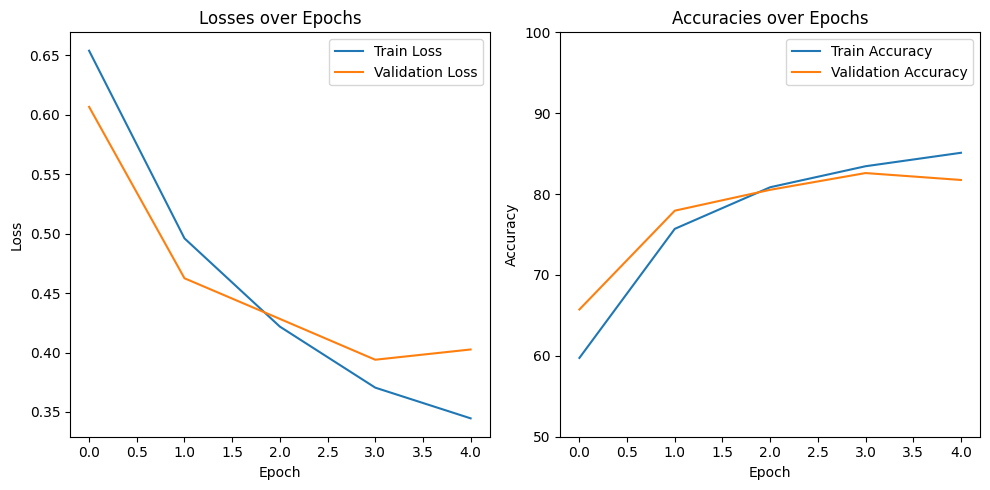

In [24]:
plot_loss_acc(train_losses, test_losses, train_accuracies, test_accuracies)

In [25]:
# def predict_sentiment(net, vocab, sequence):
#     sequence = tokenizer(sequence)
#     vocab_dict = {token: index for index, token in enumerate(vocab)}
#     sequence = [vocab_dict[word] for word in sequence] 
    
#     sequence = torch.tensor([sequence], device=device)
#     output = net(sequence)
#     return 'positive' if output > 0.5 else 'negative'

In [26]:
# predict_sentiment(net, vocab, 'I had a great time')

## Using convolutional neural networks 

CNNs can be used for natural language processing. Any text sequence can be seen as a one-dimensional image. In this way, one-dimnesional CNNs can process local features in text. 

In this section, we will use the textCNN model, showing how to design a CNN architecture for representing single text.

We implement one-dimensional cross-correlation in the following `corr1d` function. Given an input tensor X and a kernel tensor K, it return the output tensor Y

In [27]:
def corr1d(X, K):
    w = K.shape[0]
    Y = torch.zeros((X.shape[0] - w + 1))
    for i in range(Y.shape[0]):
        Y[i] = (X[i:i+w]*K).sum()
    return Y 

With one-dimnesional input with multiple channels, the convolution kernel neeeds to have the same numnber of input channels. Then for each channle, we perform a cross-correlation operation on the 1-d tensor of the input and the 1-d tensor of the convolutional kernel, summing the results over all the channels to produce the 1-d output tensor. 

In [28]:
def corr1d_multi_in(X, K):
    # First, iterate through the 0th dimension (channel dimension) of `X` and
    # `K`. Then, add them together
    return sum(corr1d(x, k) for x, k in zip(X, K))

In [29]:
X = torch.tensor([[0, 1, 2, 3, 4, 5, 6],
              [1, 2, 3, 4, 5, 6, 7],
              [2, 3, 4, 5, 6, 7, 8]])
K = torch.tensor([[1, 2], [3, 4], [-1, -3]])
corr1d_multi_in(X, K)

tensor([ 2.,  8., 14., 20., 26., 32.])

We can then use pooling to extract the highest value from sequence representations as the most important feature across time steps. For a multi-channel input where each channel stores values at different time steps, the output at each channel is the maximum value for that channel. 

The textCNN model takes individual pretrained token representations as input, then obtains and transforms sequence representations for the downstream application. 

For a single text sequence with $n$ tokens reprensented by $d$-dimensional vectors, the width, height and number of channels of the input tensor are $n$, 1 and $d$, respectively. The textCNN model transforms the input into the output as follows: 

1. Define multiple 1d conv kernels and perform convolution operation separately on the inputs. 
2. Perform max over time pooling on all the output channels, and then concatenate all the scalar pooling outputs as a vector. 
3. Transform the concatenated vector into the ouptut categories using the fully connected layer. 


In [30]:
class TextCNN(nn.Module):
    def __init__(self, vocab_size, embed_size, kernel_sizes, num_channels, **kwargs):
        super(TextCNN, self).__init__(*kwargs)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        # embedding layer not to be trained 
        self.constant_embedding = nn.Embedding(vocab_size, embed_size)
        self.dropout = nn.Dropout(0.5)
        self.decoder = nn.Linear(sum(num_channels), 1)
        # max over time pooling layer has no parameters, 
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.relu = nn.ReLU()
        # Create multiple one-dimensional conv layers 
        self.convs = nn.ModuleList()
        for c, k in zip(num_channels, kernel_sizes):
            self.convs.append(nn.Conv1d(2*embed_size, c, k))
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, inputs):
        # Concatenate two embedding layers outputs with shape (batch size, no. of tokens, token vector dimension) 
        embeddings = torch.cat((self.embedding(inputs), self.constant_embedding(inputs)), dim=2)
        # Per the input format of one-d conv layers, 
        # rearrange the tensor so that the second dimension stores channels 
        embeddings = embeddings.permute(0, 2, 1)
        # for each 1d conv layer, after max over time pooling, a tensor of shape (batch size, no. of channels, 1)
        # is obtained. Remove the last dimension and concatenate along channels 
        encoding = torch.cat([torch.squeeze(self.relu(self.pool(conv(embeddings))), dim=-1) for conv in self.convs ], dim=1 )
        outputs = self.decoder(self.dropout(encoding))
        return self.sigmoid(outputs.squeeze())


In [31]:
embed_size, kernel_sizes, nums_channels = 100, [3, 4, 5], [100, 100, 100]

net = TextCNN(len(vocab), embed_size, kernel_sizes, nums_channels)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net.to(device)

def init_weights(module):
    if type(module) in (nn.Linear, nn.Conv1d):
        nn.init.xavier_uniform_(module.weight)
net.apply(init_weights)

TextCNN(
  (embedding): Embedding(44127, 100)
  (constant_embedding): Embedding(44127, 100)
  (dropout): Dropout(p=0.5, inplace=False)
  (decoder): Linear(in_features=300, out_features=1, bias=True)
  (pool): AdaptiveAvgPool1d(output_size=1)
  (relu): ReLU()
  (convs): ModuleList(
    (0): Conv1d(200, 100, kernel_size=(3,), stride=(1,))
    (1): Conv1d(200, 100, kernel_size=(4,), stride=(1,))
    (2): Conv1d(200, 100, kernel_size=(5,), stride=(1,))
  )
  (sigmoid): Sigmoid()
)

Let's use the GloVe embedding as before

In [32]:
net.embedding.weight.data.copy_(torch.tensor(embedding_matrix))
net.constant_embedding.weight.data.copy_(torch.tensor(embedding_matrix))
net.constant_embedding.weight.requires_grad = False


In [33]:
lr, num_epochs = 0.001, 5
optimizer = torch.optim.Adam(net.parameters(), lr=lr)
loss = nn.BCELoss()

In [34]:
train_losses, test_losses, train_accuracies, test_accuracies = train(net, optimizer, num_epochs, train_dataloader, 
                                          test_dataloader, device, loss, show_every=200, Bert=False)


======== Epoch 1 / 5 ========
Training...
  Batch 200 / 782.
Training loss: 0.638  Training acc: 62.359
  Batch 400 / 782.
Training loss: 0.410  Training acc: 82.562
  Batch 600 / 782.
Training loss: 0.335  Training acc: 86.578
  Training epoch took: 0:00:48

Running Validation...
Epoch 0: Train Loss: 0.4275, Validation Loss: 0.2839, Train Accuracy: 79.47%, Validation Accuracy: 88.40%

======== Epoch 2 / 5 ========
Training...
  Batch 200 / 782.
Training loss: 0.205  Training acc: 92.281
  Batch 400 / 782.
Training loss: 0.204  Training acc: 92.219
  Batch 600 / 782.
Training loss: 0.194  Training acc: 92.328
  Training epoch took: 0:00:45

Running Validation...
Epoch 1: Train Loss: 0.2015, Validation Loss: 0.2727, Train Accuracy: 92.28%, Validation Accuracy: 88.87%

======== Epoch 3 / 5 ========
Training...
  Batch 200 / 782.
Training loss: 0.134  Training acc: 95.438
  Batch 400 / 782.
Training loss: 0.117  Training acc: 96.016
  Batch 600 / 782.
Training loss: 0.121  Training acc: 

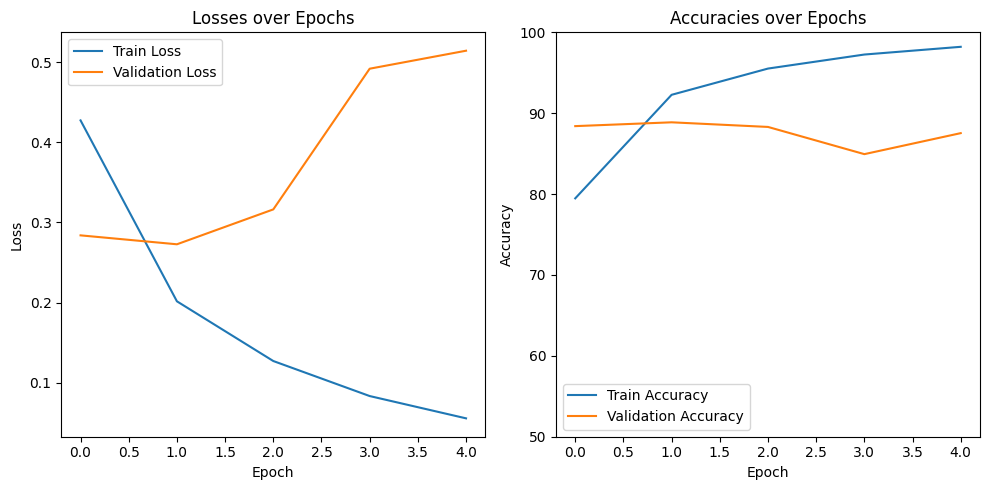

In [35]:
plot_loss_acc(train_losses, test_losses, train_accuracies, test_accuracies)

## Fine tuning BERT 

The pretrained model BERT requires minimal architecture changes for a wide range of natural language processing tasks. 
We will create a custom dataset that will return batch of sentences truncated to the maximum token BERT can take.
Let's first look at the maximal length of sentence when using the BERT tokenizer on a preprocessed text. 

In [36]:
from transformers import BertTokenizer, BertForSequenceClassification
from torch.nn import functional as F

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')  # or any other tokenizer
# X = df["review"]
# X = X.apply(stringprocess)

# sentences_tokenized = [tokenizer.tokenize(sentence) for sentence in X]

In [37]:
# max_length = max([len(sen) for sen in sentences_tokenized])
# print('Max sentence length: ', max_length)

In [38]:
class BertDataset(Dataset):
    def __init__(self, df, tokenizer, max_length=512):
        self.data = df['review']
        self.targets = df['sentiment']
        self.max_length = max_length
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        # Get the data and target for the given index
        data_point = self.data.iloc[index]
        data_point = stringprocess(data_point)
        inputs = self.tokenizer(data_point, padding='max_length', truncation=True, max_length=self.max_length, 
                                return_tensors='pt')
        
        inputs_ids = inputs['input_ids'].squeeze(0)
        attention_masks = inputs['attention_mask'].squeeze(0)
        
        target = self.targets.iloc[index]

        return inputs_ids, attention_masks, torch.tensor(target, dtype=torch.float32)
    


In [39]:
train_dataset = BertDataset(train_df, tokenizer)
test_dataset = BertDataset(test_df, tokenizer)

In [40]:
from torch.utils.data import DataLoader
batch_size = 4
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [41]:
batch = next(iter(train_dataloader))

In [42]:
from transformers import AdamW, BertConfig
from transformers import BertForSequenceClassification, BertConfig


model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',  # Use the 12-layer BERT model with an uncased vocabulary.
    num_labels=1,  # The number of output labels—2 for binary classification.
    output_attentions=False,  # Whether the model returns attention weights.
    output_hidden_states=False,  # Whether the model returns all hidden states.
)

model.classifier = torch.nn.Sequential(
    torch.nn.Linear(model.config.hidden_size, model.config.num_labels),
    torch.nn.Sigmoid()
)

# Define the device to run the model on (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Tell pytorch to run this model on the GPU.
model = model.to(device)

# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (30522, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              (

In [43]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW (model.parameters(),
                  lr =1e-6, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8, # args.adam_epsilon  - default is 1e-8.
                  weight_decay=0.05
                )

from transformers import get_linear_schedule_with_warmup

# Number of training epochs (authors recommend between 2 and 4)
num_epochs = 2
# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * num_epochs
# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [44]:
train_losses, test_losses, train_accuracies, test_accuracies = train(model, optimizer, num_epochs, train_dataloader, 
                                          test_dataloader, device, loss, show_every=20, Bert=True)


======== Epoch 1 / 2 ========
Training...
  Batch 20 / 6250.
Training loss: 0.698  Training acc: 56.250
  Batch 40 / 6250.
Training loss: 0.700  Training acc: 53.750
  Batch 60 / 6250.
Training loss: 0.703  Training acc: 55.000
  Batch 80 / 6250.
Training loss: 0.736  Training acc: 41.250
  Batch 100 / 6250.
Training loss: 0.678  Training acc: 55.000
  Batch 120 / 6250.
Training loss: 0.699  Training acc: 40.000
  Batch 140 / 6250.
Training loss: 0.692  Training acc: 50.000
  Batch 160 / 6250.
Training loss: 0.688  Training acc: 50.000
  Batch 180 / 6250.
Training loss: 0.681  Training acc: 66.250
  Batch 200 / 6250.
Training loss: 0.702  Training acc: 47.500
  Batch 220 / 6250.
Training loss: 0.690  Training acc: 53.750
  Batch 240 / 6250.
Training loss: 0.685  Training acc: 53.750
  Batch 260 / 6250.
Training loss: 0.687  Training acc: 48.750
  Batch 280 / 6250.
Training loss: 0.683  Training acc: 50.000
  Batch 300 / 6250.
Training loss: 0.660  Training acc: 60.000
  Batch 320 / 62

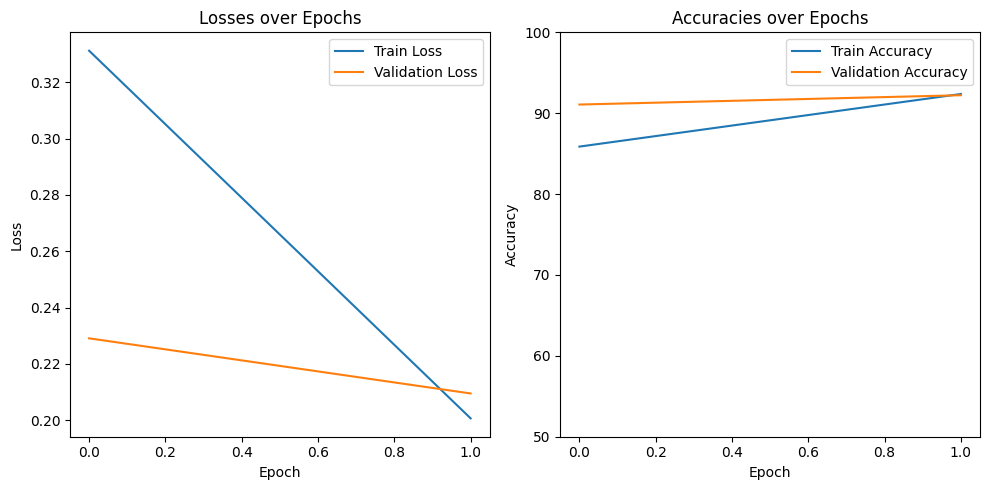

In [45]:
plot_loss_acc(train_losses, test_losses, train_accuracies, test_accuracies)